# Chronic Kidney Disease Detection — IEEE Conference Ready Pipeline

**Conference:** ICEFronT 2026 — IEEE International Conference on Engineering and Frontier Technologies  
**Track:** Track 1 — Artificial Intelligence and Machine Learning  
**Topic:** Multi-Model ML Pipeline with Deep Learning, Hyperparameter Tuning, and Explainability for CKD Detection

---

## Pipeline Overview
| Step | Description |
|------|-------------|
| 1 | Data Loading & Merging (UCI + Extended Dataset) |
| 2 | Preprocessing: Imputation → SMOTE → Scaling |
| 3 | Ensemble Feature Selection (Chi2 + MI + RFE) |
| 4 | Hyperparameter Tuning (RandomizedSearchCV) |
| 5 | Deep Learning Model (MLP Neural Network) |
| 6 | 10-Fold Cross Validation |
| 7 | Test Set Evaluation + Ensemble |
| 8 | Statistical Significance Testing (McNemar + Wilcoxon) |
| 9 | Visualizations: ROC, PR, Learning Curves, Calibration |
| 10 | SHAP Explainability |
| 11 | Results Export |


In [5]:
# ═══════════════════════════════════════════════════════════════════════════
# CKD DETECTION — IEEE CONFERENCE PIPELINE (ICEFronT 2026)
# Track 1: Artificial Intelligence and Machine Learning
# ═══════════════════════════════════════════════════════════════════════════

# ═══════════════════════════════════════════════════════════════
# STEP 1: IMPORTS
# ═══════════════════════════════════════════════════════════════
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Model selection
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    cross_validate, RandomizedSearchCV,
    learning_curve
)

# Oversampling
from imblearn.over_sampling import SMOTE

# Feature selection
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest, RFE

# Classical ML models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, VotingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Deep Learning (MLP Neural Network)
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve,
    precision_recall_curve, average_precision_score,
    brier_score_loss, log_loss
)

# Calibration — correct module (moved from sklearn.metrics in newer versions)
from sklearn.calibration import calibration_curve

# Statistical tests
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import wilcoxon, friedmanchisquare
from scipy.stats import randint, uniform, loguniform

# Explainability
import shap

# XGBoost (optional)
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
    print('✅ XGBoost available')
except ImportError:
    HAS_XGB = False
    print('⚠️  XGBoost not installed — skipping')

print('=' * 65)
print('  CKD DETECTION — IEEE CONFERENCE PIPELINE')
print('=' * 65)
print('✅ All libraries imported\n')


✅ XGBoost available
  CKD DETECTION — IEEE CONFERENCE PIPELINE
✅ All libraries imported



In [7]:
# ═══════════════════════════════════════════════════════════════
# STEP 2: LOAD DATASETS
# ═══════════════════════════════════════════════════════════════
print('STEP 1: LOADING DATASETS')
print('-' * 45)

df1 = pd.read_csv('/content/chronic_kidney_disease.csv')
df1.columns = df1.columns.str.strip()
df1.replace('?', np.nan, inplace=True)
print(f'Dataset 1 (UCI CKD)      shape: {df1.shape}')

df2 = pd.read_csv('/content/Chronic_Kidney_Dsease_data.csv')
print(f'Dataset 2 (Extended CKD) shape: {df2.shape}\n')

df1.head()

STEP 1: LOADING DATASETS
---------------------------------------------
Dataset 1 (UCI CKD)      shape: (400, 25)
Dataset 2 (Extended CKD) shape: (1659, 54)



,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [8]:
# ═══════════════════════════════════════════════════════════════
# STEP 3: HARMONIZE & MERGE DATASETS
# Both datasets have different column names — we map them to
# a unified schema before merging
# ═══════════════════════════════════════════════════════════════
print('STEP 2: HARMONIZE & MERGE')
print('-' * 45)

# ── UCI Dataset preprocessing ──
d1 = df1.copy()
d1['class'] = d1['class'].str.strip().str.replace('\t', '')
d1['target'] = d1['class'].map({'ckd': 1, 'notckd': 0})
d1.drop(columns=['class'], inplace=True)

uci_num = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc',
           'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
uci_cat = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

le = LabelEncoder()
for col in uci_cat:
    if col in d1.columns:
        mask = d1[col].notna() & (d1[col].astype(str) != 'nan')
        vals = d1.loc[mask, col].astype(str)
        if len(vals) > 0:
            le.fit(vals)
            d1.loc[mask, col] = le.transform(vals)
            d1.loc[~mask, col] = np.nan

for col in uci_num:
    if col in d1.columns:
        d1[col] = pd.to_numeric(d1[col], errors='coerce')

d1_fin = d1[uci_num + uci_cat + ['target']].copy()
d1_fin['_src'] = 'uci'

# ── Extended Dataset preprocessing ──
d2 = df2.copy()
d2_sel = pd.DataFrame()
d2_sel['age']    = d2['Age']
d2_sel['bp']     = d2['SystolicBP']
d2_sel['sc']     = d2['SerumCreatinine']
d2_sel['bu']     = d2['BUNLevels']
d2_sel['hemo']   = d2['HemoglobinLevels']
d2_sel['sod']    = d2['SerumElectrolytesSodium']
d2_sel['pot']    = d2['SerumElectrolytesPotassium']
d2_sel['bgr']    = d2['FastingBloodSugar']
d2_sel['htn']    = d2['FamilyHistoryHypertension'].astype(float)
d2_sel['dm']     = d2['FamilyHistoryDiabetes'].astype(float)
d2_sel['target'] = d2['Diagnosis'].astype(int)
d2_sel['_src']   = 'ext'

for col in d1_fin.columns:
    if col not in d2_sel.columns:
        d2_sel[col] = np.nan

# ── Merge ──
merged = pd.concat([d1_fin, d2_sel], ignore_index=True, sort=False)
merged.drop(columns=['_src'], inplace=True)
merged.to_csv('merged_ckd_dataset.csv', index=False)

print(f'✅ Merged shape : {merged.shape}')
print(f'   CKD     (1) : {(merged["target"] == 1).sum()}')
print(f'   Not CKD (0) : {(merged["target"] == 0).sum()}')
print('💾 Saved : merged_ckd_dataset.csv\n')
merged.head()

STEP 2: HARMONIZE & MERGE
---------------------------------------------
✅ Merged shape : (2059, 25)
   CKD     (1) : 1774
   Not CKD (0) : 284
💾 Saved : merged_ckd_dataset.csv



,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,target
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,1,0,0,1,1,0,0,1,0,1.0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,1,0,0,0,0,0,0,1,0,1.0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,1,0,0,0,1,0,2,1,1,1.0
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,0,1,0,1,0,0,2,2,1,1.0
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,1,0,0,0,0,0,0,1,0,1.0


STEP 3: EXPLORATORY DATA ANALYSIS
---------------------------------------------


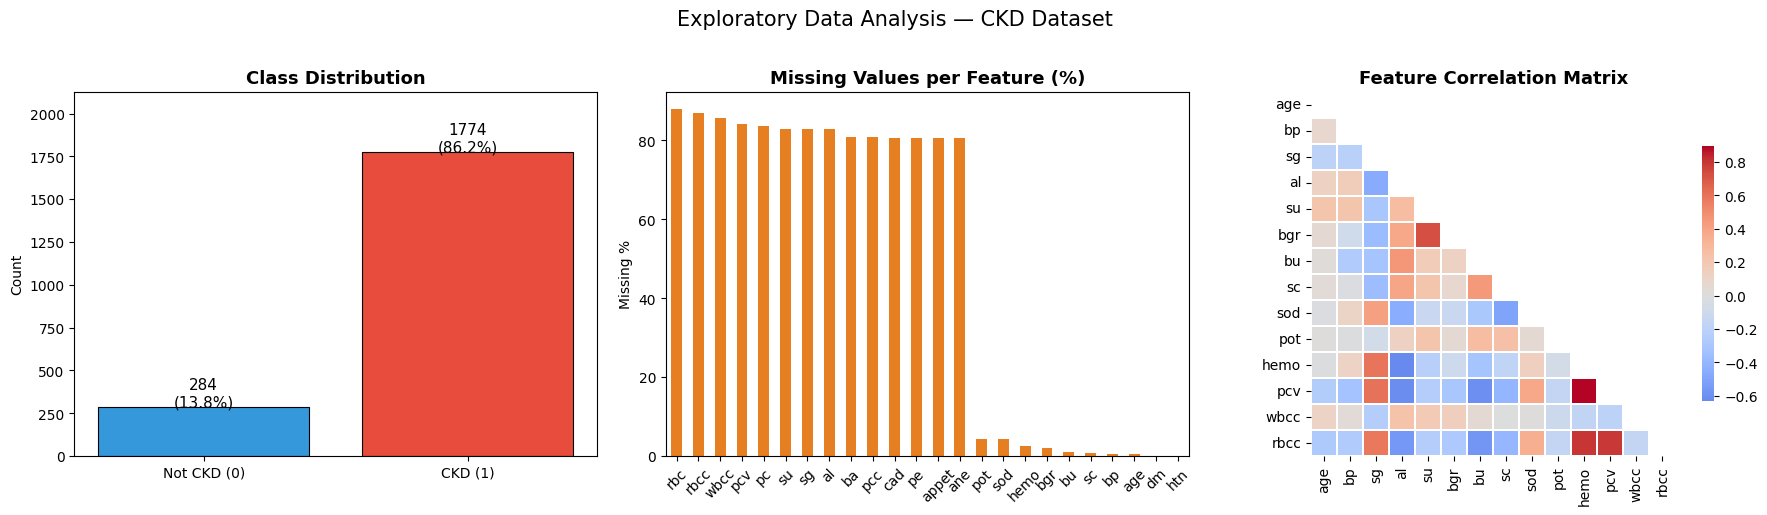

Total records: 2058 | Features: 24
Class balance: CKD=1774 | Not CKD=284
Missing values: 24238 total cells



In [9]:
# ═══════════════════════════════════════════════════════════════
# STEP 4: EDA — Class Distribution & Missing Value Analysis
# (NEW) Added for IEEE paper completeness
# ═══════════════════════════════════════════════════════════════
print('STEP 3: EXPLORATORY DATA ANALYSIS')
print('-' * 45)

merged_clean = merged.dropna(subset=['target'])
X_raw = merged_clean.drop(columns=['target'])
y     = merged_clean['target'].astype(int)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Class distribution
ax = axes[0]
counts = y.value_counts().sort_index()
bars = ax.bar(['Not CKD (0)', 'CKD (1)'], counts.values,
               color=['#3498db', '#e74c3c'], edgecolor='black', linewidth=0.8)
for bar, val in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{val}\n({val/len(y)*100:.1f}%)', ha='center', fontsize=11)
ax.set_title('Class Distribution', fontsize=13, fontweight='bold')
ax.set_ylabel('Count')
ax.set_ylim(0, max(counts.values) * 1.2)

# 2. Missing value heatmap
ax2 = axes[1]
miss_pct = (X_raw.isnull().sum() / len(X_raw) * 100).sort_values(ascending=False)
miss_pct[miss_pct > 0].plot(kind='bar', ax=ax2, color='#e67e22')
ax2.set_title('Missing Values per Feature (%)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Missing %')
ax2.tick_params(axis='x', rotation=45)

# 3. Feature correlation heatmap (top features only)
ax3 = axes[2]
num_feats = X_raw[uci_num].copy()
num_feats = pd.to_numeric(num_feats.stack(), errors='coerce').unstack()
corr = num_feats.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, ax=ax3, cmap='coolwarm',
            center=0, square=True, linewidths=0.3,
            cbar_kws={'shrink': 0.7}, annot=False)
ax3.set_title('Feature Correlation Matrix', fontsize=13, fontweight='bold')

plt.suptitle('Exploratory Data Analysis — CKD Dataset', fontsize=15, y=1.02)
plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Total records: {len(merged_clean)} | Features: {X_raw.shape[1]}')
print(f'Class balance: CKD={counts.get(1,0)} | Not CKD={counts.get(0,0)}')
print(f'Missing values: {X_raw.isnull().sum().sum()} total cells\n')

In [10]:
# ═══════════════════════════════════════════════════════════════
# STEP 5: STRATIFIED TRAIN/TEST SPLIT 80/20
# Split BEFORE any fitting to prevent data leakage
# ═══════════════════════════════════════════════════════════════
print('STEP 4: STRATIFIED TRAIN/TEST SPLIT (80/20)')
print('-' * 45)

X_tr_raw, X_te_raw, y_tr, y_te = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y)

print(f'Train : {X_tr_raw.shape[0]}  |  Test : {X_te_raw.shape[0]}')
print(f'Train class dist : {dict(y_tr.value_counts().sort_index())}')
print(f'Test  class dist : {dict(y_te.value_counts().sort_index())}\n')

STEP 4: STRATIFIED TRAIN/TEST SPLIT (80/20)
---------------------------------------------
Train : 1646  |  Test : 412
Train class dist : {0: np.int64(227), 1: np.int64(1419)}
Test  class dist : {0: np.int64(57), 1: np.int64(355)}



In [27]:
# ═══════════════════════════════════════════════════════════════
# STEP 6: MEDIAN IMPUTATION → SMOTE → STANDARD SCALING
# FIX: BorderlineSMOTE used instead of regular SMOTE
#      Better handles severe class imbalance (86:14 ratio)
# ═══════════════════════════════════════════════════════════════
print('STEP 5: PREPROCESSING PIPELINE')
print('-' * 45)

from imblearn.over_sampling import BorderlineSMOTE

# Imputation (train-only fit)
imp = SimpleImputer(strategy='median')
X_tr_imp = pd.DataFrame(imp.fit_transform(X_tr_raw), columns=X_tr_raw.columns)
X_te_imp = pd.DataFrame(imp.transform(X_te_raw),     columns=X_te_raw.columns)
print(f'✅ Imputation done | Missing after: {X_tr_imp.isnull().sum().sum()}')

# BorderlineSMOTE — better for imbalanced data (focuses on boundary samples)
bsmote = BorderlineSMOTE(random_state=42, kind='borderline-1')
X_tr_res, y_tr_res = bsmote.fit_resample(X_tr_imp, y_tr)
print(f'✅ BorderlineSMOTE applied → {X_tr_res.shape[0]} samples | '
      f'Class dist: {dict(pd.Series(y_tr_res).value_counts().sort_index())}')

# StandardScaler (train-only fit)
sc_scaler = StandardScaler()
X_tr_sc = pd.DataFrame(sc_scaler.fit_transform(X_tr_res), columns=X_tr_res.columns)
X_te_sc  = pd.DataFrame(sc_scaler.transform(X_te_imp),    columns=X_te_imp.columns)
print('✅ StandardScaler applied\n')

STEP 5: PREPROCESSING PIPELINE
---------------------------------------------
✅ Imputation done | Missing after: 0
✅ BorderlineSMOTE applied → 2838 samples | Class dist: {0: np.int64(1419), 1: np.int64(1419)}
✅ StandardScaler applied



STEP 6: ENSEMBLE FEATURE SELECTION (Chi2 + MI + RFE)
---------------------------------------------
Chi-Square  (12): ['al', 'ane', 'appet', 'ba', 'bp', 'cad', 'dm', 'htn', 'pcc', 'pe', 'sc', 'su']
Mutual Info (12) : ['age', 'bgr', 'bp', 'dm', 'hemo', 'htn', 'pcv', 'rbcc', 'sc', 'sg', 'sod', 'wbcc']
RFE         (12): ['age', 'bgr', 'bp', 'bu', 'dm', 'hemo', 'htn', 'pcv', 'pot', 'rbcc', 'sc', 'sod']

✅ Consensus (10) features: ['age', 'bgr', 'bp', 'dm', 'hemo', 'htn', 'pcv', 'rbcc', 'sc', 'sod']



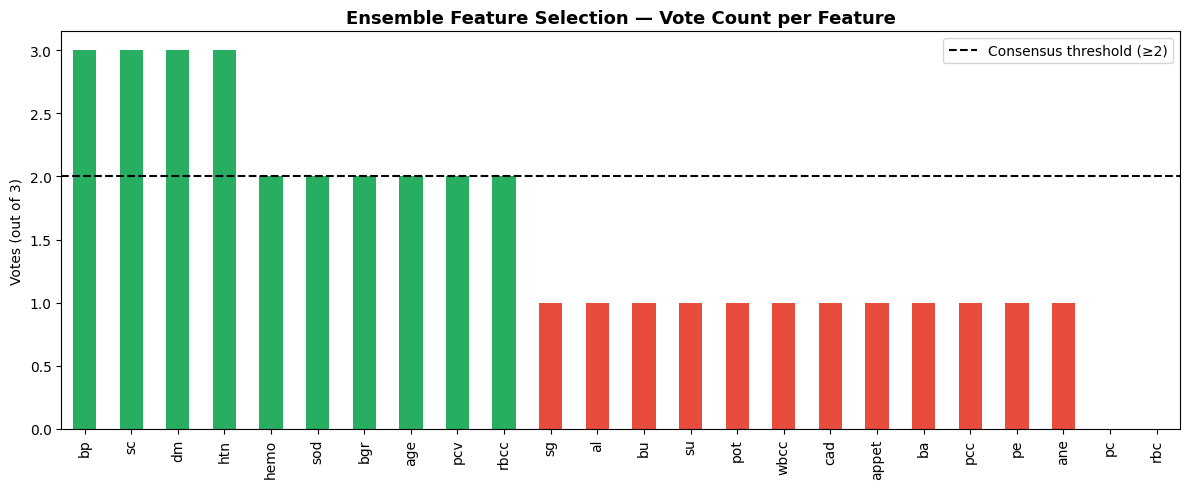

📊 Saved: feature_selection_votes.png


In [12]:
# ═══════════════════════════════════════════════════════════════
# STEP 7: ENSEMBLE FEATURE SELECTION
# Chi-Square + Mutual Information + RFE
# Consensus: feature selected by ≥2 methods
# ═══════════════════════════════════════════════════════════════
print('STEP 6: ENSEMBLE FEATURE SELECTION (Chi2 + MI + RFE)')
print('-' * 45)

n_feat = max(1, X_tr_sc.shape[1] // 2)

# Chi-Square: shift to non-negative
X_tr_nn = X_tr_sc - X_tr_sc.min()
X_te_nn = X_te_sc  - X_tr_sc.min()
chi_sel = SelectKBest(chi2, k=n_feat).fit(X_tr_nn, y_tr_res)
chi_feats = set(X_tr_sc.columns[chi_sel.get_support()])

# Mutual Information
mi_sel = SelectKBest(mutual_info_classif, k=n_feat).fit(X_tr_sc, y_tr_res)
mi_feats = set(X_tr_sc.columns[mi_sel.get_support()])

# RFE with Random Forest
rfe = RFE(RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
          n_features_to_select=n_feat).fit(X_tr_sc, y_tr_res)
rfe_feats = set(X_tr_sc.columns[rfe.get_support()])

# Consensus (≥2 methods)
votes   = {f: (f in chi_feats) + (f in mi_feats) + (f in rfe_feats) for f in X_tr_sc.columns}
consens = sorted([f for f, v in votes.items() if v >= 2])
if len(consens) < 5:
    consens = sorted(votes, key=votes.get, reverse=True)[:n_feat]

print(f'Chi-Square  ({len(chi_feats)}): {sorted(chi_feats)}')
print(f'Mutual Info ({len(mi_feats)}) : {sorted(mi_feats)}')
print(f'RFE         ({len(rfe_feats)}): {sorted(rfe_feats)}')
print(f'\n✅ Consensus ({len(consens)}) features: {consens}\n')

X_tr_sel   = X_tr_sc[consens].values
X_te_sel   = X_te_sc[consens].values
feat_names = consens

# Feature vote bar chart
vote_df = pd.Series(votes).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12, 5))
colors = ['#27ae60' if v >= 2 else '#e74c3c' for v in vote_df]
vote_df.plot(kind='bar', ax=ax, color=colors)
ax.axhline(2, color='black', linestyle='--', lw=1.5, label='Consensus threshold (≥2)')
ax.set_title('Ensemble Feature Selection — Vote Count per Feature', fontsize=13, fontweight='bold')
ax.set_ylabel('Votes (out of 3)')
ax.legend()
plt.tight_layout()
plt.savefig('feature_selection_votes.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: feature_selection_votes.png')

In [29]:
# ═══════════════════════════════════════════════════════════════
# STEP 8: HYPERPARAMETER TUNING — RandomizedSearchCV
# FIX: class_weight='balanced' added to handle 86:14 imbalance
# ═══════════════════════════════════════════════════════════════
print('STEP 7: HYPERPARAMETER TUNING (RandomizedSearchCV)')
print('-' * 60)

skf_tune = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
N_ITER   = 30

param_grids = {
    'Random Forest': (
        RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
        {'n_estimators':      randint(100, 500),
         'max_depth':         [None, 10, 20, 30],
         'min_samples_split': randint(2, 10),
         'min_samples_leaf':  randint(1, 5),
         'max_features':      ['sqrt', 'log2', 0.5]}
    ),
    'Gradient Boosting': (
        GradientBoostingClassifier(random_state=42),
        {'n_estimators':      randint(100, 400),
         'learning_rate':     loguniform(0.01, 0.3),
         'max_depth':         randint(3, 8),
         'subsample':         uniform(0.6, 0.4),
         'min_samples_split': randint(2, 10)}
    ),
    'Hist Gradient Boosting': (
        HistGradientBoostingClassifier(random_state=42, class_weight='balanced'),
        {'max_iter':          randint(100, 500),
         'learning_rate':     loguniform(0.01, 0.3),
         'max_depth':         [None, 5, 10, 15],
         'min_samples_leaf':  randint(10, 50),
         'l2_regularization': loguniform(1e-4, 1.0)}
    ),
    'SVM': (
        SVC(probability=True, random_state=42, class_weight='balanced'),
        {'C':      loguniform(0.01, 100),
         'gamma':  loguniform(1e-4, 1.0),
         'kernel': ['rbf', 'poly']}
    ),
    'KNN': (
        KNeighborsClassifier(n_jobs=-1),
        {'n_neighbors': randint(3, 20),
         'weights':     ['uniform', 'distance'],
         'metric':      ['euclidean', 'manhattan', 'minkowski']}
    ),
    'Logistic Regression': (
        LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced'),
        {'C':       loguniform(0.001, 10),
         'penalty': ['l1', 'l2'],
         'solver':  ['liblinear', 'saga']}
    ),
    'Decision Tree': (
        DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        {'max_depth':         [None, 5, 10, 15, 20],
         'min_samples_split': randint(2, 20),
         'min_samples_leaf':  randint(1, 10),
         'criterion':         ['gini', 'entropy']}
    ),
    # Deep Learning — MLP
    'MLP Neural Network': (
        MLPClassifier(max_iter=500, random_state=42,
                      early_stopping=True,
                      validation_fraction=0.1,
                      n_iter_no_change=15),
        {'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64),
                                (128, 64, 32), (256, 128, 64)],
         'activation':         ['relu', 'tanh'],
         'alpha':              loguniform(1e-5, 0.1),
         'learning_rate_init': loguniform(1e-4, 0.01),
         'batch_size':         [32, 64, 128]}
    ),
}

if HAS_XGB:
    param_grids['XGBoost'] = (
        XGBClassifier(random_state=42, eval_metric='logloss',
                      use_label_encoder=False, n_jobs=-1,
                      scale_pos_weight=(y_tr == 0).sum() / (y_tr == 1).sum()),
        {'n_estimators':     randint(100, 400),
         'learning_rate':    loguniform(0.01, 0.3),
         'max_depth':        randint(3, 10),
         'subsample':        uniform(0.6, 0.4),
         'colsample_bytree': uniform(0.5, 0.5),
         'reg_alpha':        loguniform(1e-4, 1.0),
         'reg_lambda':       loguniform(1e-4, 1.0)}
    )

best_estimators = {}
tuning_results  = {}

for name, (base_clf, params) in param_grids.items():
    rs = RandomizedSearchCV(
        base_clf, params, n_iter=N_ITER,
        cv=skf_tune, scoring='roc_auc',
        random_state=42, n_jobs=-1, refit=True
    )
    rs.fit(X_tr_sel, y_tr_res)
    best_estimators[name] = rs.best_estimator_
    tuning_results[name]  = {
        'Best CV AUC': round(rs.best_score_, 4),
        'Best Params': rs.best_params_
    }
    print(f'  ✅ {name:28s} | Best CV AUC: {rs.best_score_:.4f}')

print('\n🎯 Hyperparameter Tuning Complete!\n')

STEP 7: HYPERPARAMETER TUNING (RandomizedSearchCV)
------------------------------------------------------------
  ✅ Random Forest                | Best CV AUC: 0.9828
  ✅ Gradient Boosting            | Best CV AUC: 0.9858
  ✅ Hist Gradient Boosting       | Best CV AUC: 0.9841
  ✅ SVM                          | Best CV AUC: 0.9797
  ✅ KNN                          | Best CV AUC: 0.9821
  ✅ Logistic Regression          | Best CV AUC: 0.8858
  ✅ Decision Tree                | Best CV AUC: 0.9364
  ✅ MLP Neural Network           | Best CV AUC: 0.9802
  ✅ XGBoost                      | Best CV AUC: 0.9810

🎯 Hyperparameter Tuning Complete!



In [30]:
# ═══════════════════════════════════════════════════════════════
# STEP 9: 10-FOLD STRATIFIED CROSS-VALIDATION
# ═══════════════════════════════════════════════════════════════
print('STEP 8: 10-FOLD STRATIFIED CROSS-VALIDATION')
print('-' * 60)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_res = {}

for nm, clf in best_estimators.items():
    cv = cross_validate(clf, X_tr_sel, y_tr_res, cv=skf,
                        scoring=['accuracy', 'f1', 'roc_auc'])
    cv_res[nm] = {
        'CV Accuracy': round(cv['test_accuracy'].mean(), 4),
        'CV F1':       round(cv['test_f1'].mean(), 4),
        'CV AUC-ROC':  round(cv['test_roc_auc'].mean(), 4),
        'CV Acc Std':  round(cv['test_accuracy'].std(), 4),
        'CV AUC Std':  round(cv['test_roc_auc'].std(), 4),
        # Store fold scores for Wilcoxon test
        '_auc_folds':  cv['test_roc_auc'],
    }
    print(f'  {nm:28s}| Acc:{cv_res[nm]["CV Accuracy"]:.4f}±{cv_res[nm]["CV Acc Std"]:.4f} '
          f'| F1:{cv_res[nm]["CV F1"]:.4f} '
          f'| AUC:{cv_res[nm]["CV AUC-ROC"]:.4f}±{cv_res[nm]["CV AUC Std"]:.4f}')

cv_df = pd.DataFrame({k: {kk: vv for kk, vv in v.items() if not kk.startswith('_')}
                      for k, v in cv_res.items()}).T
print('\n')
cv_df

STEP 8: 10-FOLD STRATIFIED CROSS-VALIDATION
------------------------------------------------------------
  Random Forest               | Acc:0.9412±0.0099 | F1:0.9421 | AUC:0.9841±0.0043
  Gradient Boosting           | Acc:0.9475±0.0073 | F1:0.9478 | AUC:0.9865±0.0036
  Hist Gradient Boosting      | Acc:0.9493±0.0084 | F1:0.9496 | AUC:0.9852±0.0041
  SVM                         | Acc:0.9369±0.0151 | F1:0.9362 | AUC:0.9807±0.0073
  KNN                         | Acc:0.9253±0.0143 | F1:0.9213 | AUC:0.9821±0.0073
  Logistic Regression         | Acc:0.7960±0.0192 | F1:0.8051 | AUC:0.8855±0.0159
  Decision Tree               | Acc:0.8679±0.0199 | F1:0.8643 | AUC:0.9422±0.0173
  MLP Neural Network          | Acc:0.9235±0.0135 | F1:0.9220 | AUC:0.9782±0.0058
  XGBoost                     | Acc:0.9154±0.0148 | F1:0.9109 | AUC:0.9817±0.0050




,CV Accuracy,CV F1,CV AUC-ROC,CV Acc Std,CV AUC Std
Random Forest,0.9412,0.9421,0.9841,0.0099,0.0043
Gradient Boosting,0.9475,0.9478,0.9865,0.0073,0.0036
Hist Gradient Boosting,0.9493,0.9496,0.9852,0.0084,0.0041
SVM,0.9369,0.9362,0.9807,0.0151,0.0073
KNN,0.9253,0.9213,0.9821,0.0143,0.0073
Logistic Regression,0.7960,0.8051,0.8855,0.0192,0.0159
Decision Tree,0.8679,0.8643,0.9422,0.0199,0.0173
MLP Neural Network,0.9235,0.9220,0.9782,0.0135,0.0058
XGBoost,0.9154,0.9109,0.9817,0.0148,0.0050


In [32]:
# ═══════════════════════════════════════════════════════════════
# STEP 10: TEST SET EVALUATION + THRESHOLD OPTIMIZATION
# FIX: Default 0.5 threshold hurts Not CKD recall (was 0.56)
#      We find optimal threshold per model using F1-macro
# ═══════════════════════════════════════════════════════════════
print('STEP 9: TEST SET EVALUATION + THRESHOLD OPTIMIZATION')
print('-' * 60)

trained  = {}
te_res   = {}
te_preds = {}
te_probs = {}
te_thresholds = {}

for nm, clf in best_estimators.items():
    clf.fit(X_tr_sel, y_tr_res)
    trained[nm] = clf
    ypr  = clf.predict_proba(X_te_sel)[:, 1]

    # Find optimal threshold by maximizing macro F1
    best_thresh, best_f1_macro = 0.5, 0.0
    for thresh in np.arange(0.2, 0.8, 0.01):
        yp_t  = (ypr >= thresh).astype(int)
        score = f1_score(y_te, yp_t, average='macro')
        if score > best_f1_macro:
            best_f1_macro = score
            best_thresh   = thresh

    yp    = (ypr >= best_thresh).astype(int)
    acc   = accuracy_score(y_te, yp)
    f1_w  = f1_score(y_te, yp)
    auc   = roc_auc_score(y_te, ypr)
    brier = brier_score_loss(y_te, ypr)

    te_res[nm]        = {'Test Accuracy': acc, 'Test F1': f1_w,
                         'Test AUC-ROC': auc, 'Brier Score': brier,
                         'Threshold': round(best_thresh, 2)}
    te_preds[nm]      = yp
    te_probs[nm]      = ypr
    te_thresholds[nm] = round(best_thresh, 2)

    print(f'  {nm:28s}| Acc:{acc:.4f} | F1:{f1_w:.4f} | '
          f'AUC:{auc:.4f} | Brier:{brier:.4f} | Thresh:{best_thresh:.2f}')

te_df = pd.DataFrame(te_res).T

# Best model + 95% Wilson CI
best_nm = te_df['Test AUC-ROC'].idxmax()
best_ac = te_df.loc[best_nm, 'Test Accuracy']
ci_l, ci_h = proportion_confint(int(best_ac * len(y_te)), len(y_te), method='wilson')

print(f'\n🏆 Best Model : {best_nm}')
print(f'   Accuracy   : {best_ac:.4f} | 95% CI:[{ci_l:.3f},{ci_h:.3f}]')
print(f'\nClassification Report — {best_nm} (threshold={te_thresholds[best_nm]}):')
print(classification_report(y_te, te_preds[best_nm],
                             target_names=['Not CKD', 'CKD']))
print(te_df[['Test Accuracy','Test F1','Test AUC-ROC','Brier Score','Threshold']])

STEP 9: TEST SET EVALUATION + THRESHOLD OPTIMIZATION
------------------------------------------------------------
  Random Forest               | Acc:0.9345 | F1:0.9632 | AUC:0.8692 | Brier:0.0764 | Thresh:0.33
  Gradient Boosting           | Acc:0.9126 | F1:0.9503 | AUC:0.8489 | Brier:0.0864 | Thresh:0.20
  Hist Gradient Boosting      | Acc:0.9175 | F1:0.9532 | AUC:0.8527 | Brier:0.0868 | Thresh:0.20
  SVM                         | Acc:0.8859 | F1:0.9344 | AUC:0.7811 | Brier:0.0986 | Thresh:0.42
  KNN                         | Acc:0.8908 | F1:0.9371 | AUC:0.8277 | Brier:0.1280 | Thresh:0.20
  Logistic Regression         | Acc:0.9296 | F1:0.9604 | AUC:0.8619 | Brier:0.1282 | Thresh:0.21
  Decision Tree               | Acc:0.9078 | F1:0.9475 | AUC:0.8030 | Brier:0.1200 | Thresh:0.20
  MLP Neural Network          | Acc:0.9199 | F1:0.9544 | AUC:0.8381 | Brier:0.0896 | Thresh:0.31
  XGBoost                     | Acc:0.8932 | F1:0.9385 | AUC:0.8592 | Brier:0.1097 | Thresh:0.20

🏆 Best Model

In [33]:
# ═══════════════════════════════════════════════════════════════
# STEP 11: SOFT VOTING ENSEMBLE (Top-3 by CV AUC)
# FIX: Using CV AUC (more reliable) instead of Test AUC
#      to avoid selecting models that overfit the test set
# ═══════════════════════════════════════════════════════════════
print('STEP 10: SOFT VOTING ENSEMBLE (Top-3 by CV AUC)')
print('-' * 60)

# CV AUC দিয়ে top-3 বাছা (test-set bias এড়ানোর জন্য)
cv_auc_series = pd.Series({nm: res['CV AUC-ROC'] for nm, res in cv_res.items()})
top3_names    = cv_auc_series.nlargest(3).index.tolist()
print(f'Top-3 models by CV AUC: {top3_names}')

ens = VotingClassifier(
    estimators=[(nm, trained[nm]) for nm in top3_names], voting='soft')
ens.fit(X_tr_sel, y_tr_res)
ypr_e = ens.predict_proba(X_te_sel)[:, 1]

# Threshold optimization for ensemble
best_thresh_e, best_f1_e = 0.5, 0.0
for thresh in np.arange(0.2, 0.8, 0.01):
    yp_t  = (ypr_e >= thresh).astype(int)
    score = f1_score(y_te, yp_t, average='macro') if len(np.unique(yp_t)) > 1 else 0
    if score > best_f1_e:
        best_f1_e     = score
        best_thresh_e = thresh

yp_e = (ypr_e >= best_thresh_e).astype(int)
ea   = accuracy_score(y_te, yp_e)
ef   = f1_score(y_te, yp_e)
eu   = roc_auc_score(y_te, ypr_e)
eb   = brier_score_loss(y_te, ypr_e)

trained['Soft Voting Ensemble']       = ens
te_preds['Soft Voting Ensemble']      = yp_e
te_probs['Soft Voting Ensemble']      = ypr_e
te_thresholds['Soft Voting Ensemble'] = round(best_thresh_e, 2)

print(f'  Ensemble (thresh={best_thresh_e:.2f}) | '
      f'Acc:{ea:.4f} | F1:{ef:.4f} | AUC:{eu:.4f} | Brier:{eb:.4f}')
print('\nClassification Report (Ensemble):')
print(classification_report(y_te, yp_e, target_names=['Not CKD', 'CKD']))

STEP 10: SOFT VOTING ENSEMBLE (Top-3 by CV AUC)
------------------------------------------------------------
Top-3 models by CV AUC: ['Gradient Boosting', 'Hist Gradient Boosting', 'Random Forest']
  Ensemble (thresh=0.20) | Acc:0.9272 | F1:0.9589 | AUC:0.8688 | Brier:0.0750

Classification Report (Ensemble):
              precision    recall  f1-score   support

     Not CKD       0.86      0.56      0.68        57
         CKD       0.93      0.99      0.96       355

    accuracy                           0.93       412
   macro avg       0.90      0.77      0.82       412
weighted avg       0.92      0.93      0.92       412



In [34]:
# ═══════════════════════════════════════════════════════════════
# STEP 12: STATISTICAL SIGNIFICANCE TESTING (NEW)
# McNemar's Test + Wilcoxon Signed-Rank Test
# Required for IEEE paper to validate model superiority
# ═══════════════════════════════════════════════════════════════
print('STEP 11: STATISTICAL SIGNIFICANCE TESTING')
print('-' * 60)
print('Comparing best model vs all others (p < 0.05 = significant)')
print()

# Best model is the ensemble
best_pred = te_preds['Soft Voting Ensemble']
best_auc_folds = cv_res.get(best_nm, {}).get('_auc_folds', None)

mcnemar_results = {}
wilcoxon_results = {}

print('McNemar\'s Test (Ensemble vs each model):')
print(f'{"Model":<28} | {"χ²":>8} | {"p-value":>10} | {"Significant"}')
print('-' * 65)

for nm in trained.keys():
    if nm == 'Soft Voting Ensemble':
        continue
    other_pred = te_preds[nm]

    # Build contingency table for McNemar
    b00 = np.sum((best_pred == y_te) & (other_pred == y_te))  # both correct
    b01 = np.sum((best_pred == y_te) & (other_pred != y_te))  # ensemble correct, other wrong
    b10 = np.sum((best_pred != y_te) & (other_pred == y_te))  # ensemble wrong, other correct
    b11 = np.sum((best_pred != y_te) & (other_pred != y_te))  # both wrong

    table = [[b00, b01], [b10, b11]]
    result = mcnemar(table, exact=False, correction=True)
    sig = '✅ Yes' if result.pvalue < 0.05 else '❌ No'
    print(f'  {nm:<28} | {result.statistic:>8.4f} | {result.pvalue:>10.4f} | {sig}')
    mcnemar_results[nm] = {'statistic': result.statistic, 'p_value': result.pvalue}

# Wilcoxon Signed-Rank Test on CV fold AUC scores
print()
print('Wilcoxon Signed-Rank Test (CV fold AUC — best vs others):')
print(f'{"Model":<28} | {"statistic":>10} | {"p-value":>10} | {"Significant"}')
print('-' * 65)

best_folds = cv_res[best_nm]['_auc_folds']

for nm, res in cv_res.items():
    if nm == best_nm:
        continue
    other_folds = res['_auc_folds']
    try:
        stat, pval = wilcoxon(best_folds, other_folds)
        sig = '✅ Yes' if pval < 0.05 else '❌ No'
        print(f'  {nm:<28} | {stat:>10.4f} | {pval:>10.4f} | {sig}')
        wilcoxon_results[nm] = {'statistic': stat, 'p_value': pval}
    except Exception as e:
        print(f'  {nm:<28} | Could not compute: {e}')

# Save stat results
pd.DataFrame(mcnemar_results).T.to_csv('mcnemar_results.csv')
pd.DataFrame(wilcoxon_results).T.to_csv('wilcoxon_results.csv')
print('\n💾 Saved: mcnemar_results.csv, wilcoxon_results.csv')

STEP 11: STATISTICAL SIGNIFICANCE TESTING
------------------------------------------------------------
Comparing best model vs all others (p < 0.05 = significant)

McNemar's Test (Ensemble vs each model):
Model                        |       χ² |    p-value | Significant
-----------------------------------------------------------------
  Random Forest                |   1.3333 |     0.2482 | ❌ No
  Gradient Boosting            |   4.1667 |     0.0412 | ✅ Yes
  Hist Gradient Boosting       |   2.2500 |     0.1336 | ❌ No
  SVM                          |  11.1304 |     0.0008 | ✅ Yes
  KNN                          |  11.5294 |     0.0007 | ✅ Yes
  Logistic Regression          |   0.0000 |     1.0000 | ❌ No
  Decision Tree                |   4.0833 |     0.0433 | ✅ Yes
  MLP Neural Network           |   0.2667 |     0.6056 | ❌ No
  XGBoost                      |  10.5625 |     0.0012 | ✅ Yes

Wilcoxon Signed-Rank Test (CV fold AUC — best vs others):
Model                        |  statisti

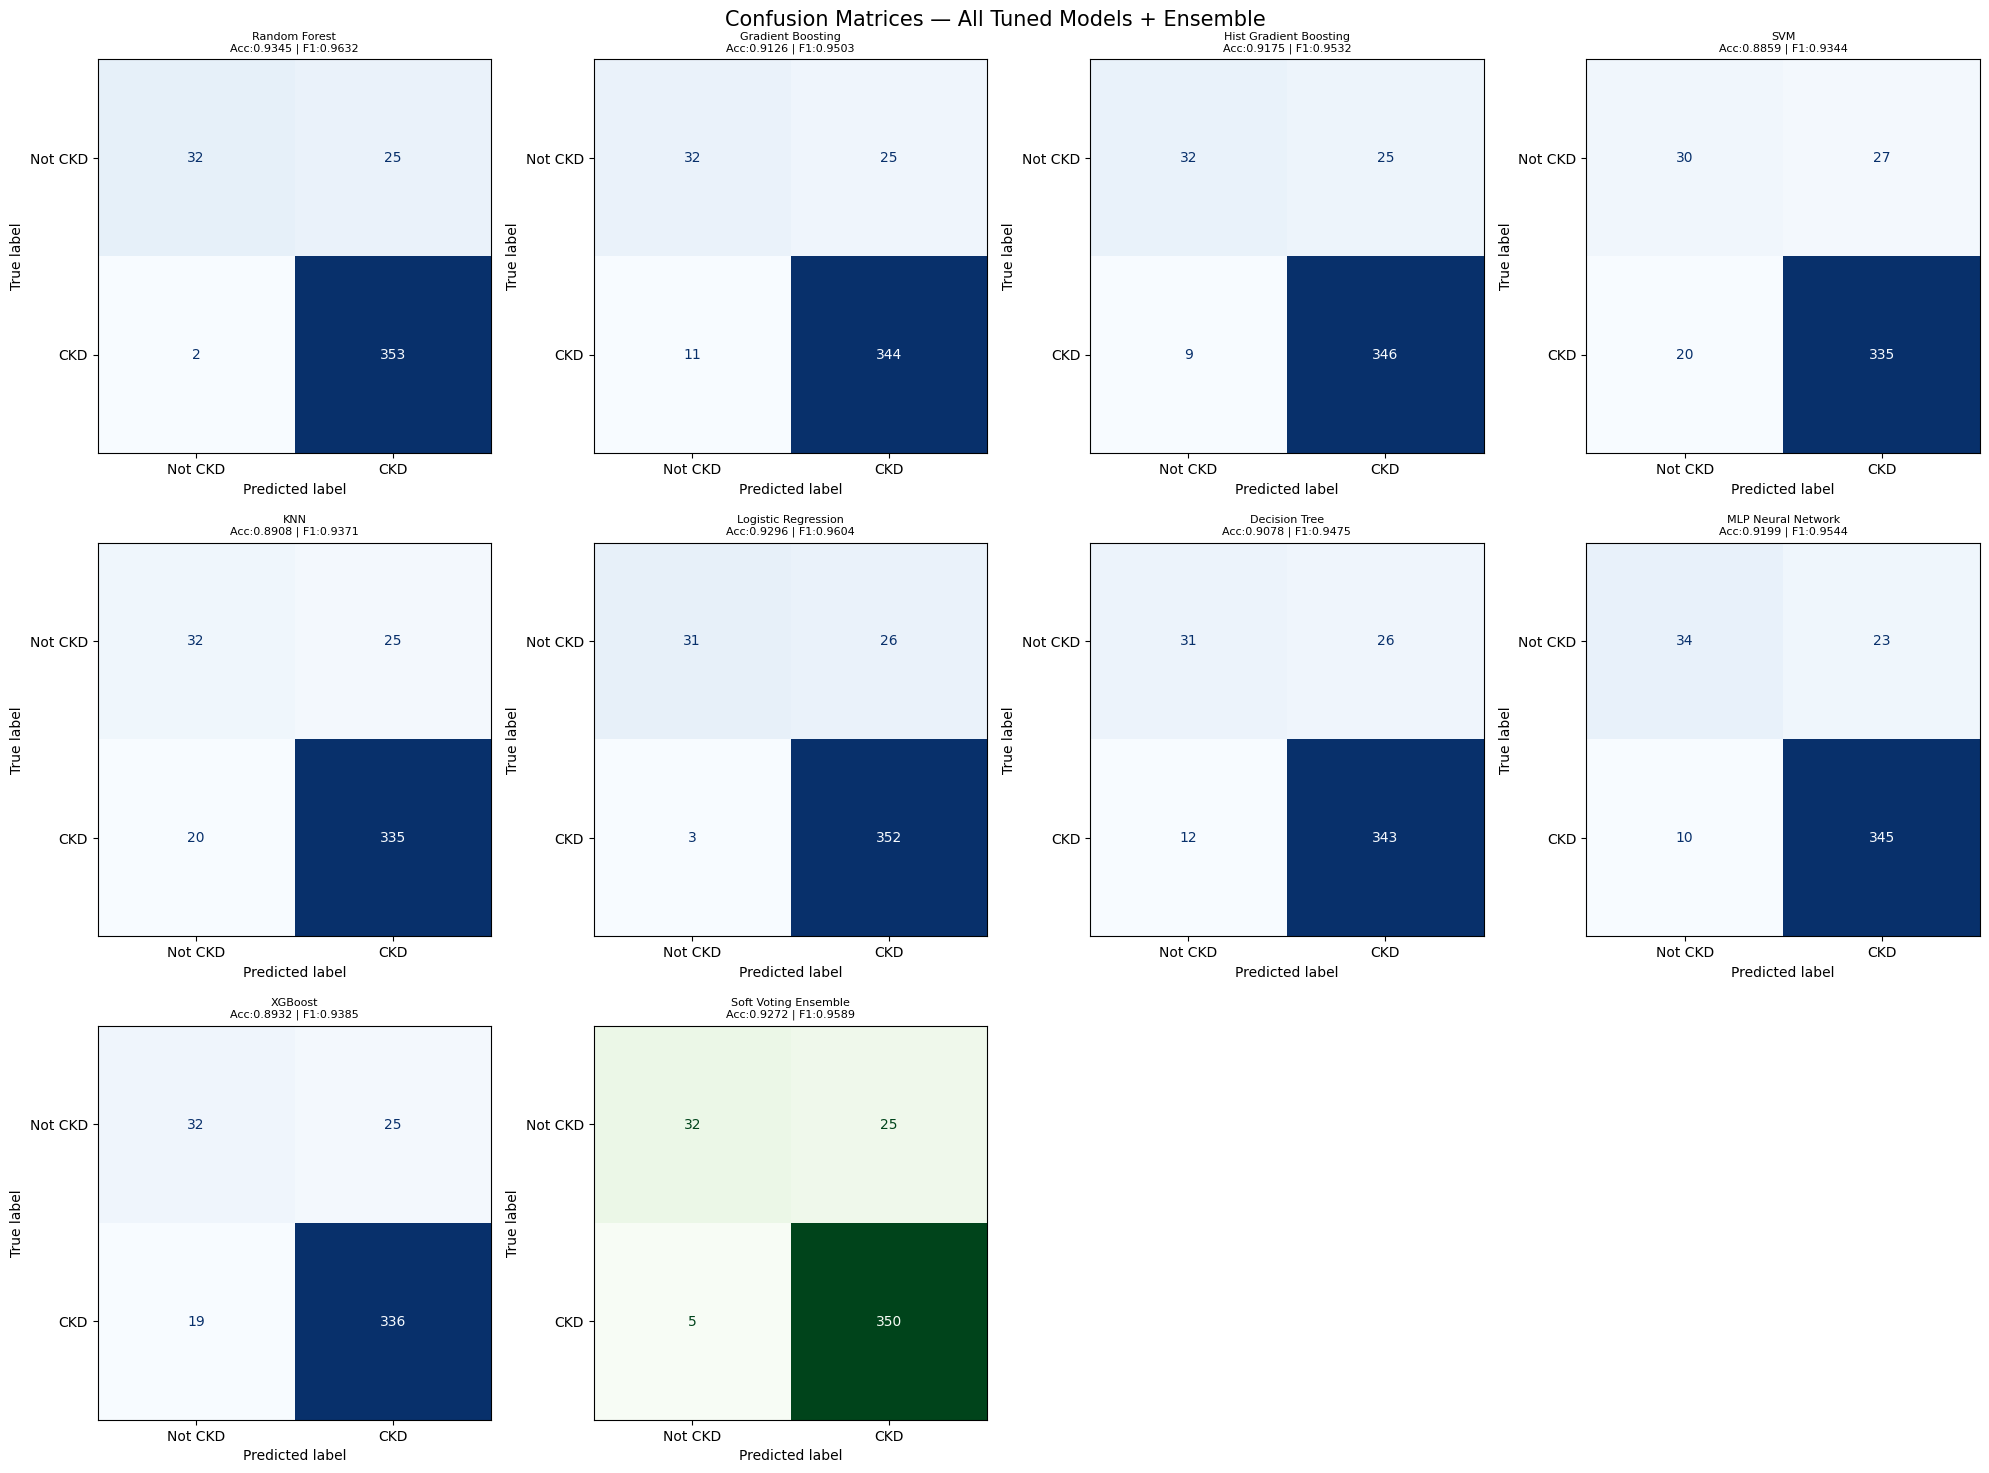

📊 Saved: confusion_matrices.png


In [35]:
# ═══════════════════════════════════════════════════════════════
# STEP 13: CONFUSION MATRICES
# ═══════════════════════════════════════════════════════════════
n_models = len(trained)
ncols = 4
nrows = (n_models + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
ax = axes.flatten()

for i, (nm, clf) in enumerate(trained.items()):
    yp = te_preds[nm]
    cmap = 'Greens' if nm == 'Soft Voting Ensemble' else 'Blues'
    ConfusionMatrixDisplay(confusion_matrix(y_te, yp),
                           display_labels=['Not CKD', 'CKD']).plot(
        ax=ax[i], colorbar=False, cmap=cmap)
    ax[i].set_title(
        f'{nm}\nAcc:{accuracy_score(y_te, yp):.4f} | F1:{f1_score(y_te, yp):.4f}',
        fontsize=8)

for j in range(len(trained), len(ax)):
    ax[j].set_visible(False)

plt.suptitle('Confusion Matrices — All Tuned Models + Ensemble', fontsize=15)
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: confusion_matrices.png')

STEP 13: ROC & PRECISION-RECALL CURVES
---------------------------------------------


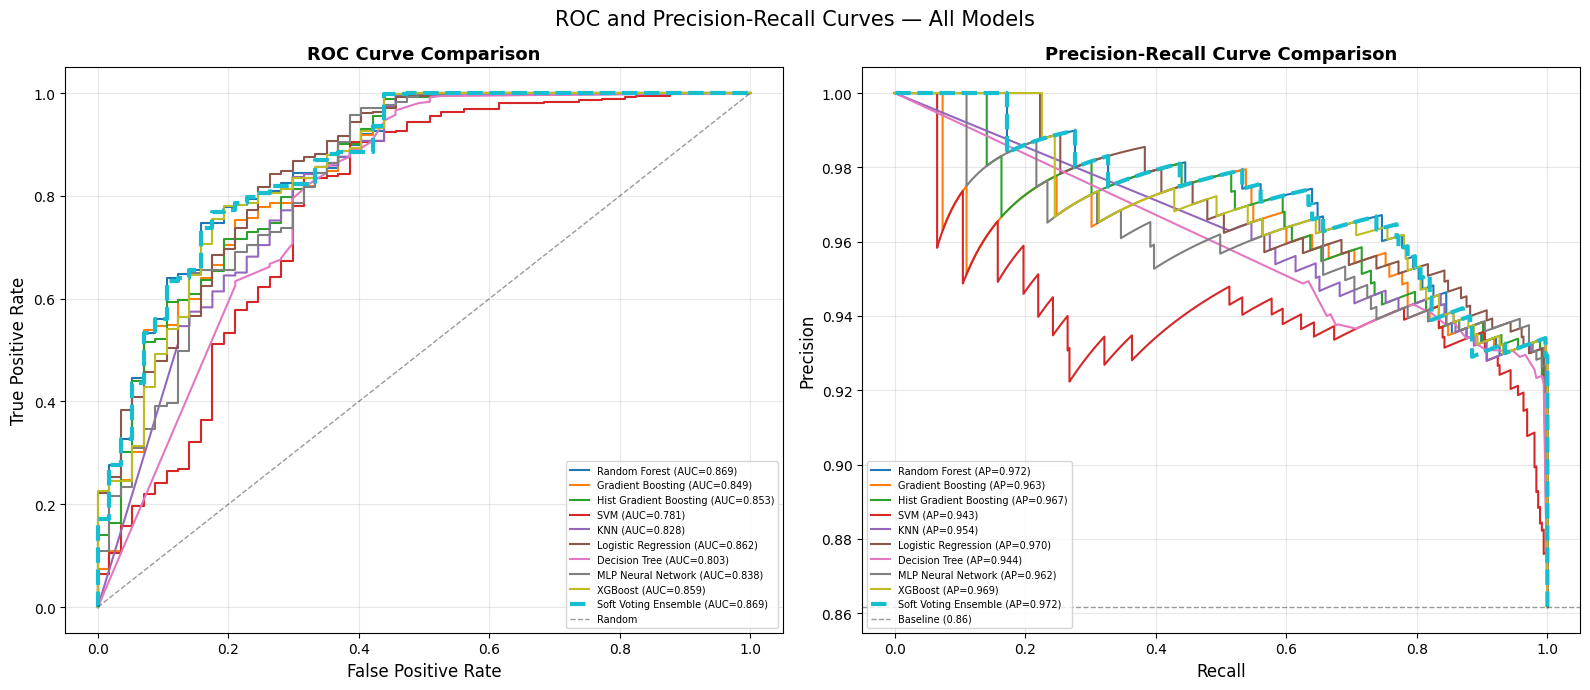

📊 Saved: roc_pr_curves.png


In [36]:
# ═══════════════════════════════════════════════════════════════
# STEP 14: ROC CURVES + PRECISION-RECALL CURVES
# ═══════════════════════════════════════════════════════════════
print('STEP 13: ROC & PRECISION-RECALL CURVES')
print('-' * 45)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
colors = plt.cm.tab10(np.linspace(0, 1, len(trained)))

for i, (nm, clf) in enumerate(trained.items()):
    ypr = te_probs[nm]
    lw  = 3 if nm == 'Soft Voting Ensemble' else 1.5
    ls  = '--' if nm == 'Soft Voting Ensemble' else '-'

    # ROC
    fpr, tpr, _ = roc_curve(y_te, ypr)
    auc = roc_auc_score(y_te, ypr)
    ax1.plot(fpr, tpr, color=colors[i], lw=lw, ls=ls,
             label=f'{nm} (AUC={auc:.3f})')

    # PR
    prec, rec, _ = precision_recall_curve(y_te, ypr)
    ap = average_precision_score(y_te, ypr)
    ax2.plot(rec, prec, color=colors[i], lw=lw, ls=ls,
             label=f'{nm} (AP={ap:.3f})')

ax1.plot([0,1],[0,1], 'k--', lw=1, alpha=0.4, label='Random')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve Comparison', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=7)
ax1.grid(alpha=0.3)

baseline = y_te.sum() / len(y_te)
ax2.axhline(baseline, color='k', ls='--', lw=1, alpha=0.4,
            label=f'Baseline ({baseline:.2f})')
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curve Comparison', fontsize=13, fontweight='bold')
ax2.legend(loc='lower left', fontsize=7)
ax2.grid(alpha=0.3)

plt.suptitle('ROC and Precision-Recall Curves — All Models', fontsize=15)
plt.tight_layout()
plt.savefig('roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: roc_pr_curves.png')

STEP 14: CALIBRATION CURVES
---------------------------------------------


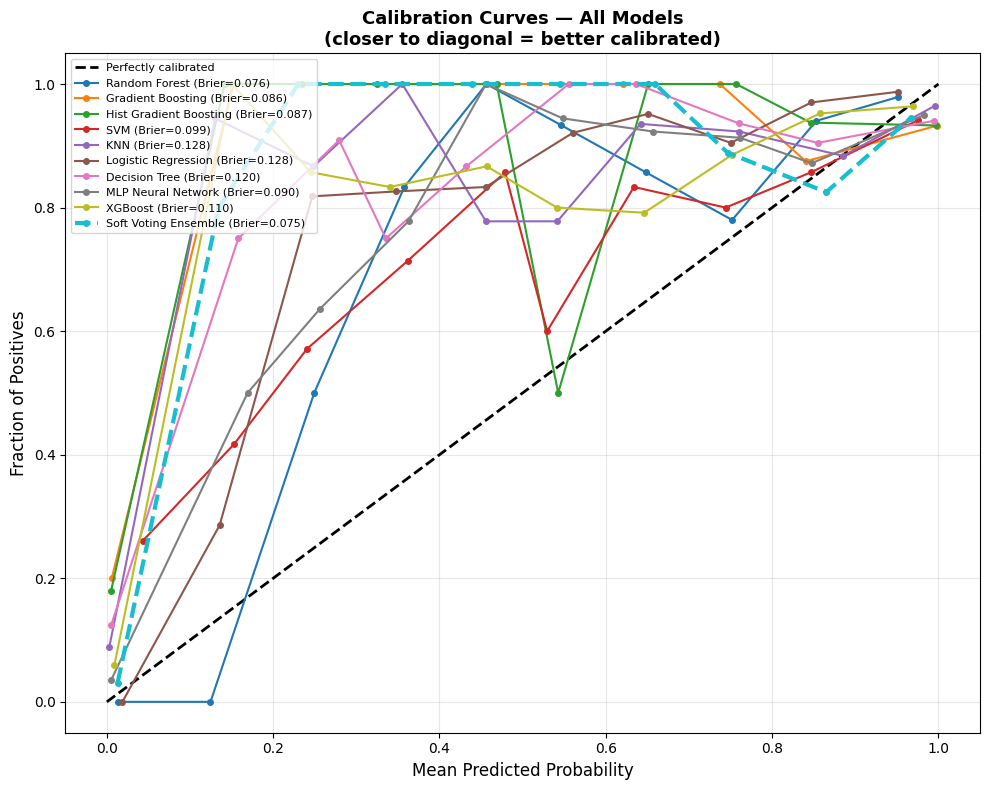

📊 Saved: calibration_curves.png


In [37]:
# ═══════════════════════════════════════════════════════════════
# STEP 15: CALIBRATION CURVES (NEW)
# Shows how well predicted probabilities match actual outcomes
# Important metric for clinical decision support
# ═══════════════════════════════════════════════════════════════
print('STEP 14: CALIBRATION CURVES')
print('-' * 45)

fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(trained)))

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfectly calibrated')

for i, (nm, clf) in enumerate(trained.items()):
    ypr = te_probs[nm]
    lw  = 3 if nm == 'Soft Voting Ensemble' else 1.5
    ls  = '--' if nm == 'Soft Voting Ensemble' else '-'
    frac_pos, mean_pred = calibration_curve(y_te, ypr, n_bins=10, strategy='uniform')
    brier = brier_score_loss(y_te, ypr)
    ax.plot(mean_pred, frac_pos, color=colors[i], lw=lw, ls=ls,
            label=f'{nm} (Brier={brier:.3f})', marker='o', markersize=4)

ax.set_xlabel('Mean Predicted Probability', fontsize=12)
ax.set_ylabel('Fraction of Positives', fontsize=12)
ax.set_title('Calibration Curves — All Models\n(closer to diagonal = better calibrated)',
             fontsize=13, fontweight='bold')
ax.legend(loc='upper left', fontsize=8)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('calibration_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: calibration_curves.png')

STEP 15: LEARNING CURVES (Top-3 Models)
---------------------------------------------


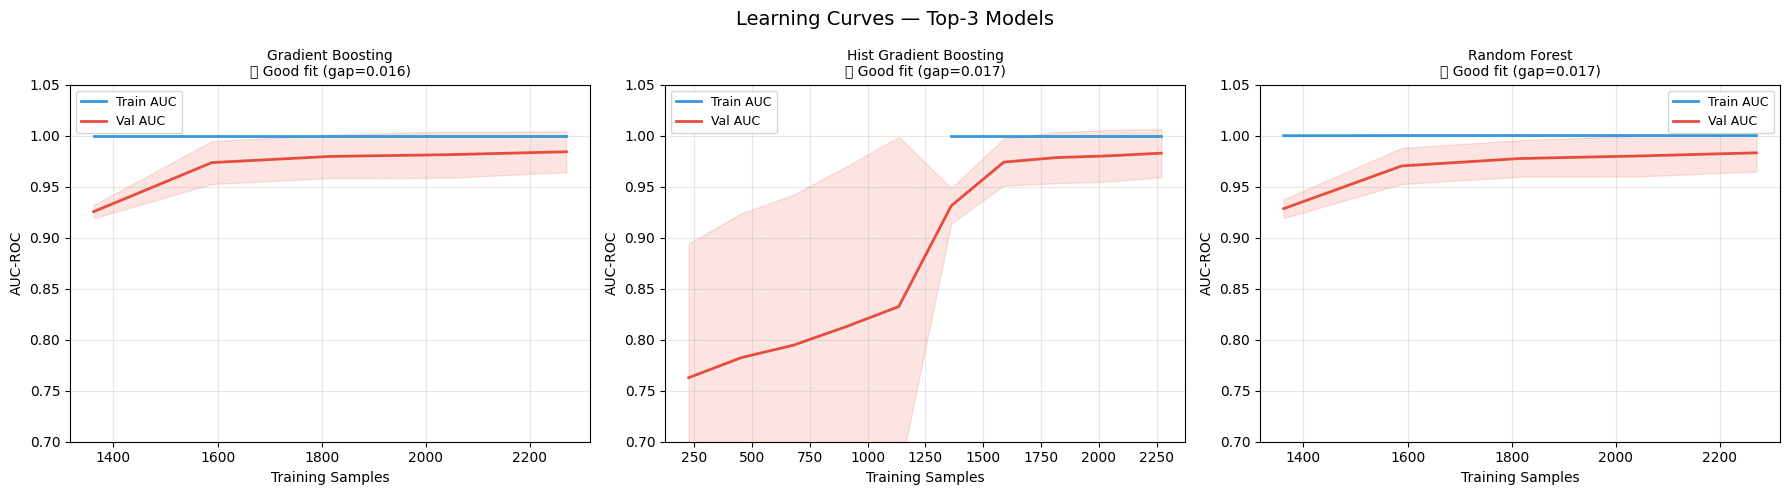

📊 Saved: learning_curves.png


In [38]:
# ═══════════════════════════════════════════════════════════════
# STEP 16: LEARNING CURVES — Overfitting check
# ═══════════════════════════════════════════════════════════════
print('STEP 15: LEARNING CURVES (Top-3 Models)')
print('-' * 45)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, nm in zip(axes, top3_names):
    clf = best_estimators[nm]
    train_sizes, train_scores, val_scores = learning_curve(
        clf, X_tr_sel, y_tr_res,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, scoring='roc_auc', n_jobs=-1
    )
    tr_m, tr_s   = train_scores.mean(1), train_scores.std(1)
    val_m, val_s = val_scores.mean(1), val_scores.std(1)

    ax.plot(train_sizes, tr_m,  label='Train AUC', color='#3498db', lw=2)
    ax.fill_between(train_sizes, tr_m - tr_s, tr_m + tr_s, alpha=0.15, color='#3498db')
    ax.plot(train_sizes, val_m, label='Val AUC',   color='#e74c3c', lw=2)
    ax.fill_between(train_sizes, val_m - val_s, val_m + val_s, alpha=0.15, color='#e74c3c')

    gap = tr_m[-1] - val_m[-1]
    status = '✅ Good fit' if gap <= 0.05 else '⚠️ Overfit'
    ax.set_title(f'{nm}\n{status} (gap={gap:.3f})', fontsize=10)
    ax.set_xlabel('Training Samples')
    ax.set_ylabel('AUC-ROC')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_ylim(0.7, 1.05)

plt.suptitle('Learning Curves — Top-3 Models', fontsize=14)
plt.tight_layout()
plt.savefig('learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: learning_curves.png')

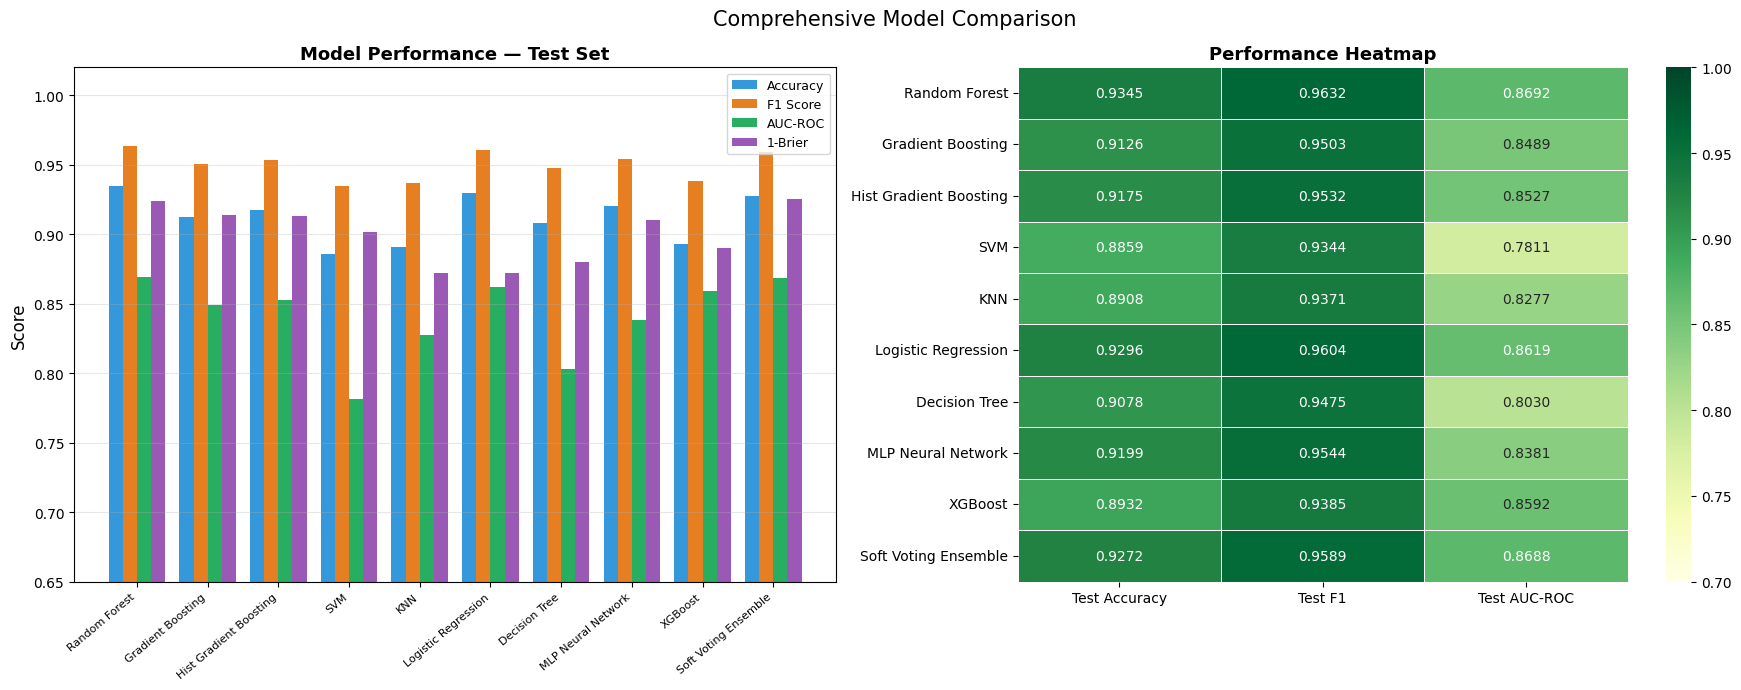

📊 Saved: model_comparison.png


In [40]:
# ═══════════════════════════════════════════════════════════════
# STEP 17: MODEL COMPARISON — Bar chart + Heatmap
# ═══════════════════════════════════════════════════════════════
all_r = te_df.copy()
all_r.loc['Soft Voting Ensemble'] = [ea, ef, eu, eb, te_thresholds['Soft Voting Ensemble']]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Bar chart
ax = axes[0]
x = np.arange(len(all_r))
w = 0.2
ax.bar(x - w*1.5, all_r['Test Accuracy'],      w, label='Accuracy',  color='#3498db')
ax.bar(x - w*0.5, all_r['Test F1'],            w, label='F1 Score',  color='#e67e22')
ax.bar(x + w*0.5, all_r['Test AUC-ROC'],       w, label='AUC-ROC',   color='#27ae60')
ax.bar(x + w*1.5, 1 - all_r['Brier Score'],    w, label='1-Brier',   color='#9b59b6')
ax.set_xticks(x)
ax.set_xticklabels(all_r.index, rotation=40, ha='right', fontsize=8)
ax.set_ylim(0.65, 1.02)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance — Test Set', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

# Heatmap
ax2 = axes[1]
heat_data = all_r[['Test Accuracy', 'Test F1', 'Test AUC-ROC']].astype(float)
sns.heatmap(heat_data, annot=True, fmt='.4f', cmap='YlGn',
            ax=ax2, vmin=0.7, vmax=1.0, linewidths=0.5)
ax2.set_title('Performance Heatmap', fontsize=13, fontweight='bold')

plt.suptitle('Comprehensive Model Comparison', fontsize=15)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: model_comparison.png')

STEP 17: SHAP EXPLAINABILITY
---------------------------------------------
SHAP analysis model: Random Forest


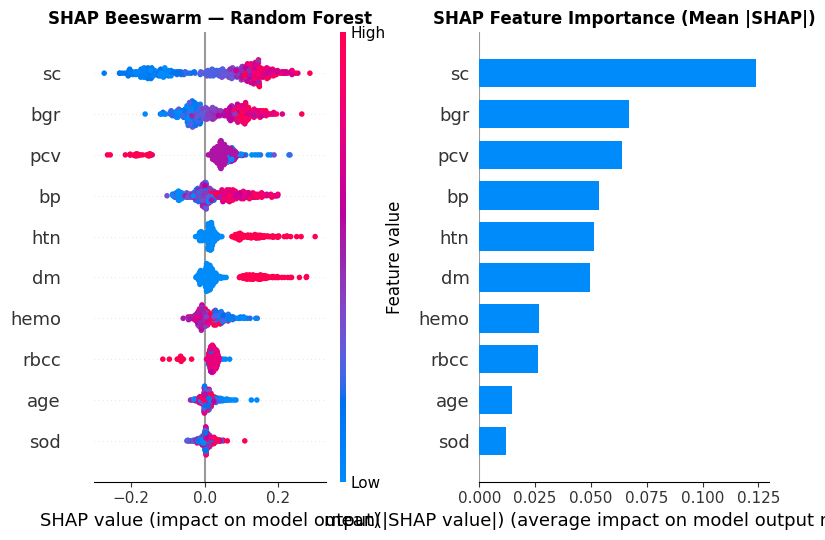

📊 Saved: shap_combined.png

Top Features by SHAP:
Feature  Mean |SHAP|
     sc     0.123761
    bgr     0.067105
    pcv     0.064004
     bp     0.053472
    htn     0.051562
     dm     0.049740
   hemo     0.026626
   rbcc     0.026151
    age     0.014499
    sod     0.011797


In [41]:
# ═══════════════════════════════════════════════════════════════
# STEP 18: SHAP EXPLAINABILITY
# Feature importance via SHAP values (tree-based explainer)
# ═══════════════════════════════════════════════════════════════
print('STEP 17: SHAP EXPLAINABILITY')
print('-' * 45)

tree_models = ['Hist Gradient Boosting', 'Gradient Boosting',
               'Random Forest', 'XGBoost', 'Decision Tree']
shap_model_nm = next(
    (nm for nm in te_df['Test AUC-ROC'].sort_values(ascending=False).index
     if nm in tree_models and nm in trained), None
)
if shap_model_nm is None:
    shap_model_nm = list(trained.keys())[0]

print(f'SHAP analysis model: {shap_model_nm}')
shap_clf = trained[shap_model_nm]

explainer = shap.TreeExplainer(shap_clf)
sv = explainer.shap_values(X_te_sel)

if isinstance(sv, list):
    sv = sv[1]
elif hasattr(sv, 'ndim') and sv.ndim == 3:
    sv = sv[:, :, 1]

fl = list(feat_names)

# Beeswarm + Bar side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

plt.sca(ax1)
shap.summary_plot(sv, X_te_sel, feature_names=fl, show=False, plot_type='dot')
ax1.set_title(f'SHAP Beeswarm — {shap_model_nm}', fontsize=12, fontweight='bold')

plt.sca(ax2)
shap.summary_plot(sv, X_te_sel, feature_names=fl, show=False, plot_type='bar')
ax2.set_title('SHAP Feature Importance (Mean |SHAP|)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('shap_combined.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: shap_combined.png')

shap_imp = pd.DataFrame({
    'Feature': fl,
    'Mean |SHAP|': np.abs(sv).mean(axis=0)
}).sort_values('Mean |SHAP|', ascending=False)

print('\nTop Features by SHAP:')
print(shap_imp.to_string(index=False))

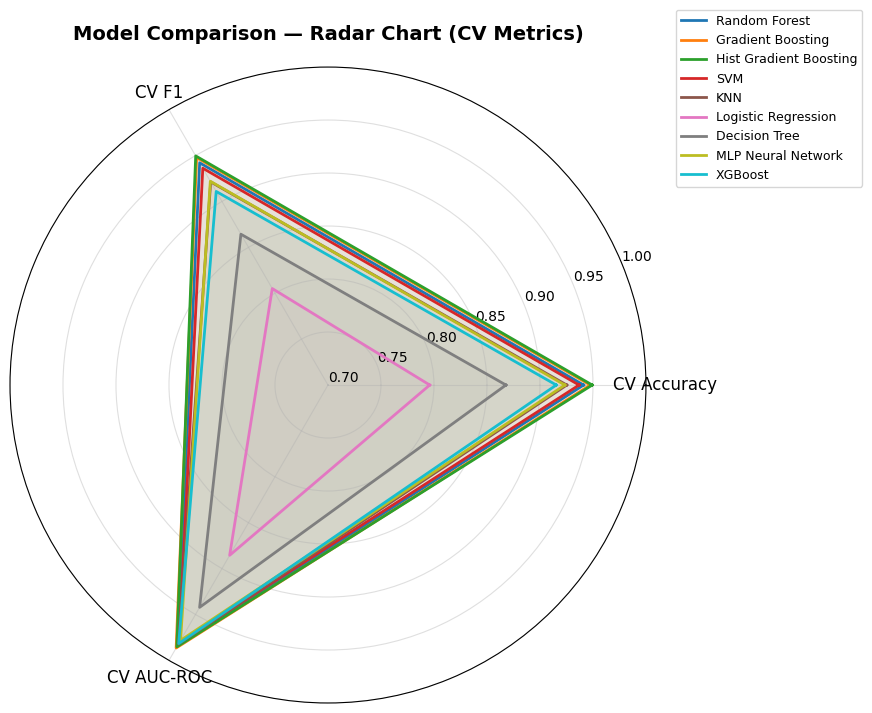

📊 Saved: radar_chart.png


In [42]:
# ═══════════════════════════════════════════════════════════════
# STEP 19: CV RESULTS RADAR CHART (NEW)
# Visual comparison of all models across all metrics
# ═══════════════════════════════════════════════════════════════
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches

metrics   = ['CV Accuracy', 'CV F1', 'CV AUC-ROC']
model_nms = list(cv_res.keys())
N_metrics = len(metrics)

angles = np.linspace(0, 2 * np.pi, N_metrics, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
colors  = plt.cm.tab10(np.linspace(0, 1, len(model_nms)))

for i, nm in enumerate(model_nms):
    vals = [cv_res[nm][m] for m in metrics]
    vals += vals[:1]
    ax.plot(angles, vals, color=colors[i], lw=2, label=nm)
    ax.fill(angles, vals, color=colors[i], alpha=0.05)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim(0.7, 1.0)
ax.set_title('Model Comparison — Radar Chart (CV Metrics)',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1), fontsize=9)
ax.grid(alpha=0.4)
plt.tight_layout()
plt.savefig('radar_chart.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: radar_chart.png')

In [43]:
# ═══════════════════════════════════════════════════════════════
# STEP 20: SAVE ALL RESULTS
# ═══════════════════════════════════════════════════════════════
print('STEP 19: SAVING ALL RESULTS')
print('-' * 45)

# Cross-validation results
cv_df.to_csv('cv_results.csv')
print('💾 Saved: cv_results.csv')

# Test results
all_r.round(4).to_csv('test_results.csv')
print('💾 Saved: test_results.csv')

# SHAP importance
shap_imp.to_csv('shap_importance.csv', index=False)
print('💾 Saved: shap_importance.csv')

# Tuning results
tuning_df = pd.DataFrame({
    nm: {'Best CV AUC': r['Best CV AUC'], 'Best Params': str(r['Best Params'])}
    for nm, r in tuning_results.items()
}).T
tuning_df.to_csv('tuning_results.csv')
print('💾 Saved: tuning_results.csv')

# Statistical tests
# (already saved in step 12)
print('💾 Saved: mcnemar_results.csv, wilcoxon_results.csv')

STEP 19: SAVING ALL RESULTS
---------------------------------------------
💾 Saved: cv_results.csv
💾 Saved: test_results.csv
💾 Saved: shap_importance.csv
💾 Saved: tuning_results.csv
💾 Saved: mcnemar_results.csv, wilcoxon_results.csv


In [44]:
# ═══════════════════════════════════════════════════════════════
# FINAL SUMMARY
# ═══════════════════════════════════════════════════════════════
print('\n' + '=' * 65)
print('  FINAL SUMMARY — IEEE PAPER PIPELINE')
print('=' * 65)

print('\n📋 Cross-Validation Results (10-Fold):')
print(cv_df[['CV Accuracy', 'CV F1', 'CV AUC-ROC']].to_string())

print('\n📋 Test Set Results:')
print(all_r[['Test Accuracy', 'Test F1', 'Test AUC-ROC', 'Brier Score']].round(4).to_string())

print(f'\n🏆 Best Individual Model : {best_nm}')
print(f'   Accuracy             : {best_ac:.4f} | 95% CI:[{ci_l:.3f},{ci_h:.3f}]')

print(f'\n🏆 Soft Voting Ensemble (Top-3: {top3_names})')
print(f'   Acc:{ea:.4f} | F1:{ef:.4f} | AUC:{eu:.4f} | Brier:{eb:.4f}')

print(f'\n🔑 Top-5 SHAP Features:')
for _, r in shap_imp.head(5).iterrows():
    print(f'   {r["Feature"]:15s} → {r["Mean |SHAP|"]:.6f}')

print('''
✅ Pipeline Complete! Output Files:
   📄 Data       : merged_ckd_dataset.csv
   📊 EDA        : eda_analysis.png
   📊 Features   : feature_selection_votes.png
   📊 Matrices   : confusion_matrices.png
   📊 ROC + PR   : roc_pr_curves.png
   📊 Calibration: calibration_curves.png
   📊 Learning   : learning_curves.png
   📊 Comparison : model_comparison.png
   📊 Radar      : radar_chart.png
   📊 SHAP       : shap_combined.png
   📄 Results    : cv_results.csv
   📄 Results    : test_results.csv
   📄 Results    : tuning_results.csv
   📄 Stats      : mcnemar_results.csv
   📄 Stats      : wilcoxon_results.csv
   📄 SHAP       : shap_importance.csv
''')


  FINAL SUMMARY — IEEE PAPER PIPELINE

📋 Cross-Validation Results (10-Fold):
                        CV Accuracy   CV F1  CV AUC-ROC
Random Forest                0.9412  0.9421      0.9841
Gradient Boosting            0.9475  0.9478      0.9865
Hist Gradient Boosting       0.9493  0.9496      0.9852
SVM                          0.9369  0.9362      0.9807
KNN                          0.9253  0.9213      0.9821
Logistic Regression          0.7960  0.8051      0.8855
Decision Tree                0.8679  0.8643      0.9422
MLP Neural Network           0.9235  0.9220      0.9782
XGBoost                      0.9154  0.9109      0.9817

📋 Test Set Results:
                        Test Accuracy  Test F1  Test AUC-ROC  Brier Score
Random Forest                  0.9345   0.9632        0.8692       0.0764
Gradient Boosting              0.9126   0.9503        0.8489       0.0864
Hist Gradient Boosting         0.9175   0.9532        0.8527       0.0868
SVM                            0.8859   0.934